read "bank-full.csv"。然后进行 15% 的随机采样，得到样本数据集

In [1]:
import pandas as pd
import numpy as np

# 读取原始数据集
data = pd.read_csv("bank-full.csv", sep=";")

# 进行 15% 的随机采样
sample_data = data.sample(frac=0.15, random_state=42)

# 将采样后的数据保存为 bank-sample.csv
sample_data.to_csv("bank-sample.csv", index=False)


In [11]:
sample_data

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,poutcome,deposit,age_discretized,balance_discretized,campaign_discretized,duration_discretized,pdays_discretized,previous_discretized
3776,-0.094020,blue-collar,married,secondary,no,-0.276210,yes,no,cellular,16,...,0.000000,0.000000,failure,no,7,7,0,7,0,0
9928,0.566043,services,single,secondary,no,0.828632,no,no,cellular,9,...,0.000000,0.000000,failure,no,9,12,0,2,0,0
33409,-1.508442,student,single,university,no,-0.291354,yes,no,cellular,20,...,0.000000,0.000000,failure,no,0,7,0,8,0,0
31885,0.094569,management,married,university,no,0.153972,no,no,cellular,9,...,39.976275,3.333333,failure,no,8,11,0,10,2,0
15738,1.414697,management,married,university,no,-0.407103,no,yes,cellular,21,...,0.000000,0.000000,failure,no,12,5,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,-0.942674,admin.,married,secondary,no,-0.357342,yes,no,cellular,9,...,0.000000,0.000000,failure,no,2,6,0,8,0,0
6215,1.603286,management,divorced,university,no,-0.510952,no,no,cellular,27,...,0.000000,0.000000,failure,no,12,0,0,3,0,0
43920,-0.942674,management,single,university,no,-0.147119,no,no,cellular,14,...,45.670225,10.000000,failure,no,2,9,0,12,2,2
6524,-0.659789,unemployed,single,university,no,-0.158658,yes,no,cellular,27,...,0.000000,0.000000,failure,no,4,9,1,3,0,0


样本数据中是否有缺失值

In [3]:
# 检查缺失值
missing_values = sample_data.isnull().sum()
print("缺失值情况：\n", missing_values)

缺失值情况：
 age             0
job            44
marital         0
education     288
default         0
balance         0
housing         0
loan            0
contact      1959
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     5530
deposit         0
dtype: int64


针对缺失值的处理策略：

对于数值型属性，采用均值、中位数或者插值法进行填充。
对于分类属性，使用众数进行填充，或者将缺失值单独作为一个类别。
如果缺失值过多，可能需要考虑删除样本或者属性

In [4]:
# 处理缺失值
for col in sample_data.columns:
    if sample_data[col].dtype == 'object':
        sample_data[col].fillna(sample_data[col].mode()[0], inplace=True)
    else:
        sample_data[col].fillna(sample_data[col].mean(), inplace=True)


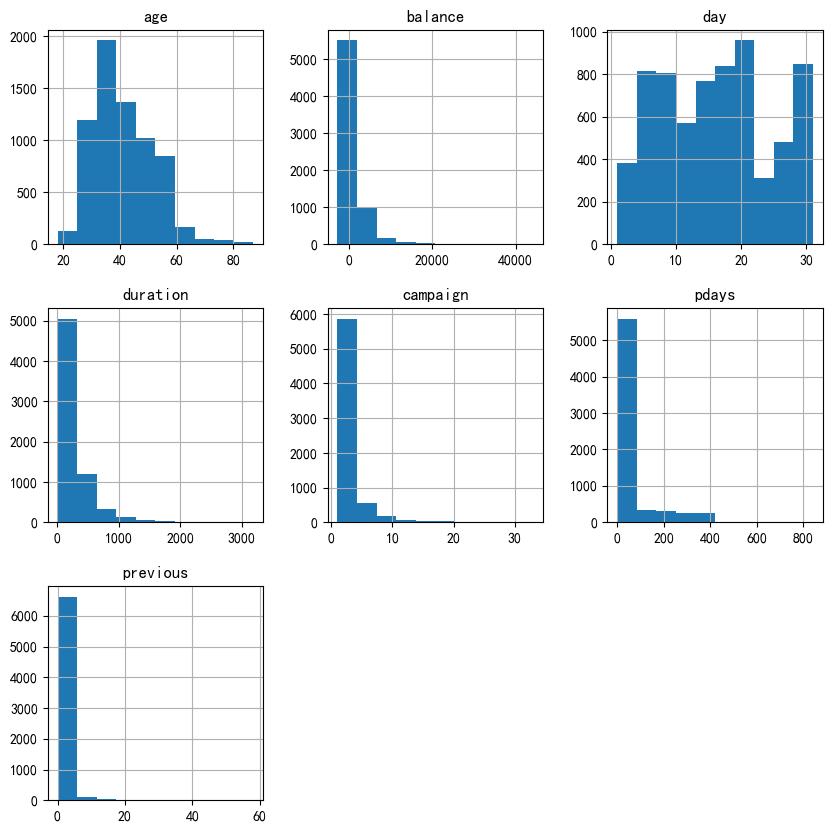

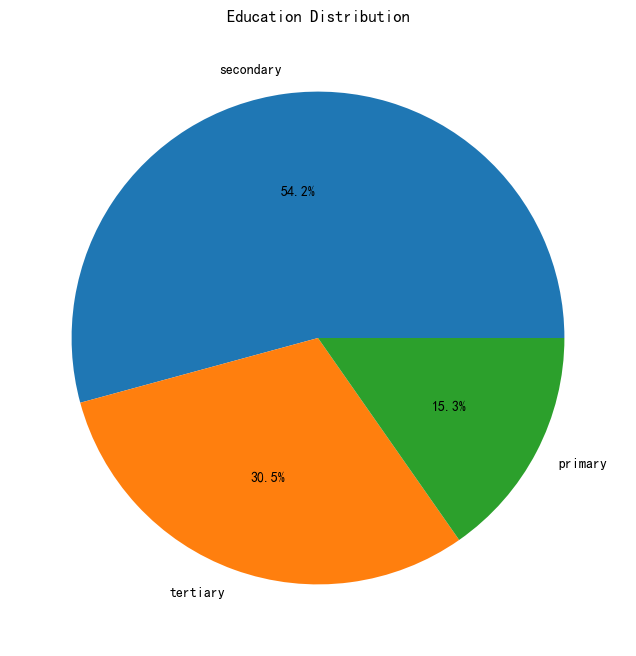

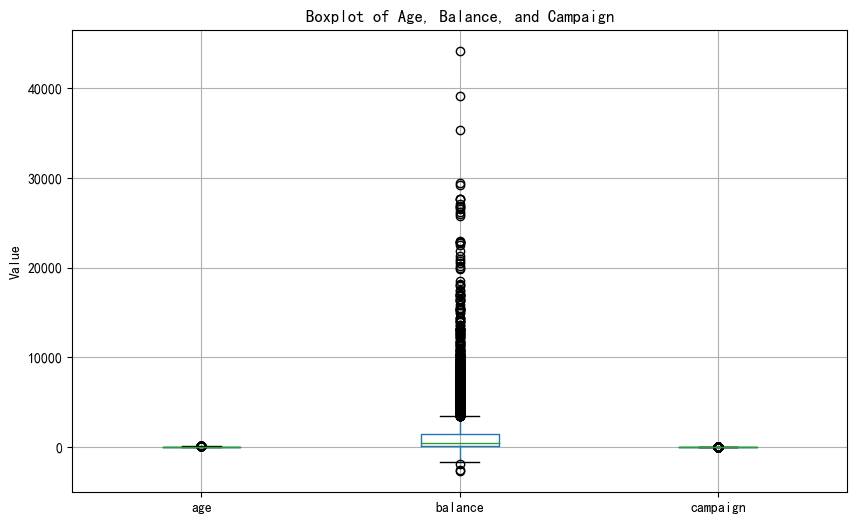

In [5]:
import matplotlib.pyplot as plt

# 直方图展示数值型数据分布
sample_data.hist(figsize=(10, 10))
plt.show()

# 饼图展示分类数据比例
plt.figure(figsize=(8, 8))
sample_data['education'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Education Distribution')
plt.ylabel('')
plt.show()

# 箱线图展示数值型数据的异常值和分布情况
plt.figure(figsize=(10, 6))
sample_data.boxplot(column=['age', 'balance', 'campaign'])
plt.title('Boxplot of Age, Balance, and Campaign')
plt.ylabel('Value')
plt.show()


In [6]:
# 第四步：将 education 属性中的取值为“tertiary”的值全部替换为“university”
sample_data['education'] = sample_data['education'].replace('tertiary', 'university')

# 第五步：将 poutcome 属性中取值为“other”的记录都删除
sample_data = sample_data[sample_data['poutcome'] != 'other']


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 对 age，balance，campaign 三个数值属性进行 z-transformation 的标准化处理
scaler = StandardScaler()
sample_data[['age', 'balance', 'campaign']] = scaler.fit_transform(sample_data[['age', 'balance', 'campaign']])

# 对 duration，pdays，previous 三个数值属性进行 [0,100] 区间上的离差标准化处理
min_max_scaler = MinMaxScaler(feature_range=(0, 100))
sample_data[['duration', 'pdays', 'previous']] = min_max_scaler.fit_transform(sample_data[['duration', 'pdays', 'previous']])


In [10]:
# 对所有的数值属性的取值做基于熵(Entropy)的离散化处理
num_attributes = ['age', 'balance', 'campaign', 'duration', 'pdays', 'previous']
for attr in num_attributes:
    num_bins = int(np.ceil(1 + np.log2(len(sample_data[attr]))))  # 使用基于熵的离散化处理计算bin数量
    sample_data[attr+'_discretized'] = pd.qcut(sample_data[attr], q=num_bins, labels=False, duplicates='drop')

# 导出经过处理的数据集
sample_data.to_csv("bank-afterpreprocessing.csv", index=False)
